Generate FEM solution for 2D plane stress problem

* Fix the right boundary in x direction; fix bottom boundary in y direction, apply uniaxial loading at top boundary
* Output dirich_idx, dirich_value; traction_idx, traction_value; bodyforce; solution; materials (E, v)
* The unit is GPa
* Please note that the node numbering in FEM and CNN is reverse in y direction

In [1]:
from PIL import Image

import meshio
import numpy as np
import matplotlib.pyplot as plt
import random
import h5py

In [2]:
# pre-define the problem
n_elem = 2**8
Fy = 222.22e-3 # GPa, along y direction
datafile = "Ti64_256x256.h5"
samples = ['G5v', 'G6a', 'Y6v', 'Y6a']
n_data = len(samples)

In [3]:
A = np.array([[1,2,3],[2,3,4],[5,6,7]])
A

array([[1, 2, 3],
       [2, 3, 4],
       [5, 6, 7]])

In [4]:
np.flip(A, axis=0)

array([[5, 6, 7],
       [2, 3, 4],
       [1, 2, 3]])

In [5]:
# im = Image.open(sample+'_XZ_128_new.tif')
im = Image.open(samples[0]+'_XZ_256.tif')
# im = Image.open('amga6__rec00001201_yz_select280_erode+dilate.tif')
# imarray = np.flip(np.array(im)/255, axis=0)
imarray = np.array(im)/255

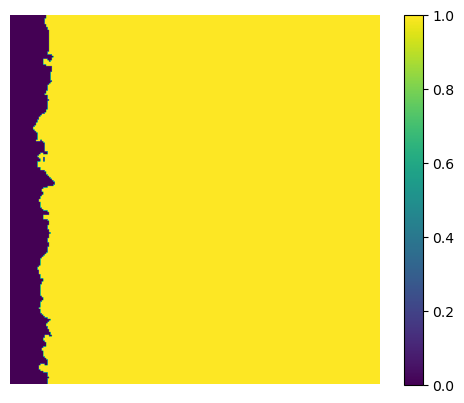

In [6]:
def plot_image(img):
    fig = plt.figure()
    im1 = plt.imshow(img)
    plt.axis('off')
    plt.colorbar(im1)

plot_image(imarray)

In [7]:
def combine_vectors(v):
    '''combine vectors v (n, n, 2) to (2xnxn)'''
    _, n, _ = v.shape
    u = np.zeros(shape=(2*n*n,))
    u[0::2] = v[:, :, 0].reshape(n*n)
    u[1::2] = v[:, :, 1].reshape(n*n)
    return u

In [8]:
def loading_type1(n, fy):
    '''
    Loading: 
    Fix the right boundary [index=-1] in x direction; 
    Fix bottom boundary [index=0] in y direction;
    Apply uniaxial force loading at top boundary [index=-1] in y direction
    0 is x, 1 is y direction
    '''

    dirich_idx = np.ones((n, n, 2))
    dirich_idx[0, :, 1] = 0. # bottom disp bc in y direction
    dirich_idx[:, -1, 0] = 0. # right disp bc in x direction
    dirich_value = np.zeros_like(dirich_idx)

    # define traction boundary, 1.0 traction boundary; 0 else
    traction_idx = np.zeros((n, n, 2))
    traction_idx[-1, :, 1] = 1. # top force bc in y direction
    traction_value = np.zeros_like(traction_idx)
    traction_value[-1, :, 1] = fy

    return dirich_idx, dirich_value, traction_idx, traction_value

In [9]:
# Create dataset
# dataset contains: dirich_idx~2xnxn, dirich_value~2xnxn, traction_idx~2xnxn, traction_value~2xnxn, material~2x(n-1)x(n-1), f~2xnxn, solution~2xnxn

dataset = {}
dirich_idx_data = np.zeros((n_data, n_elem+1, n_elem+1, 2))
dirich_value_data = np.zeros((n_data, n_elem+1, n_elem+1, 2))
traction_idx_data = np.zeros((n_data, n_elem+1, n_elem+1, 2))
traction_value_data = np.zeros((n_data, n_elem+1, n_elem+1, 2))
material_data = np.zeros((n_data, n_elem, n_elem, 2))
f_data = np.zeros((n_data, n_elem+1, n_elem+1, 2))
u_data = np.zeros((n_data, n_elem+1, n_elem+1, 2))
for i in range(n_data):
    # load the image
    im = Image.open(samples[i]+'_XZ_256.tif')
    # imarray = np.array(im)/255
    imarray = np.flip(np.array(im)/255, axis=0)

    # create the material field
    E_field, v_field = 110*imarray, 0.34*imarray
    material = np.stack((E_field, v_field), axis=2)
    material_data[i] = material 

    # define boundary conditions
    d_list = 2*np.random.rand(2, n_elem+1)-1
    t_list = 2*np.random.rand(2, n_elem+1)-1
    dirich_idx, dirich_value, traction_idx, traction_value = loading_type1(n_elem+1, Fy)
    dirich_idx_data[i] = dirich_idx
    dirich_value_data[i] = dirich_value
    traction_idx_data[i] = traction_idx
    traction_value_data[i] = traction_value
    
    # define body force field, zero
    f1, f2 = np.zeros((n_elem+1,n_elem+1)), np.zeros((n_elem+1,n_elem+1))
    f_data[i] = np.stack((f1, f2), axis=2)
    f = combine_vectors(f_data[i])

    print("Problem #-"+str(i)+" generated")

Problem #-0 generated
Problem #-1 generated
Problem #-2 generated
Problem #-3 generated


In [10]:
dataset['dirich_idx'] = dirich_idx_data
dataset['dirich_value'] = dirich_value_data
dataset['traction_idx'] = traction_idx_data
dataset['traction_value'] = traction_value_data
dataset['material'] = material_data
dataset['body_force'] = f_data
dataset['solution'] = u_data

with h5py.File(datafile, "w") as hf:
    for key, item in dataset.items():
        hf[key] = item

In [11]:
# prob.Solve(material, d_list, 'jacobi', combine_vectors(traction_value), f)
# plt.plot(prob.res_arr)
# plt.yscale('log')
# plt.show()

In [12]:
#q = prob.res_arr[-1]/prob.res_arr[-2]
#q